In [1]:
import numpy as np
import pandas as pd
import torch
from gcn_model import GCNModel
import utilities
from test_model import test_model
import os
import statistics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#remove cd34 cells
ref_labels = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref_labels.csv", index_col=0)
ref_counts = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref.csv", index_col=0)
print(ref_counts.shape)
print(ref_labels.shape)
print(ref_labels[ref_labels.labels=="cd34"].shape)
ref_counts = ref_counts.drop(ref_labels[ref_labels.labels=="cd34"].index)
ref_labels = ref_labels.drop(ref_labels[ref_labels.labels=="cd34"].index)
ref_counts.columns = ref_counts.columns.str.split("\t").str[1]
print(ref_labels.shape)
print(ref_counts.shape)
ref_labels.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref_labels.csv")
ref_counts.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref.csv")

(4733, 32738)
(4733, 1)
(463, 1)
(4270, 1)
(4270, 32738)


In [4]:
#remove cd34 cells
query_labels = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query_labels.csv", index_col=0)
query_counts = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query.csv", index_col=0)
print(query_counts.shape)
print(query_labels.shape)
print(query_labels[query_labels.labels=="cd34"].shape)
query_counts = query_counts.drop(query_labels[query_labels.labels=="cd34"].index)
query_labels = query_labels.drop(query_labels[query_labels.labels=="cd34"].index)
query_counts.columns = query_counts.columns.str.split("\t").str[1]
print(query_labels.shape)
print(query_counts.shape)
query_labels.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query_labels.csv")
query_counts.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query.csv")

(4733, 32738)
(4733, 1)
(486, 1)
(4247, 1)
(4247, 32738)


In [12]:
ref_labels = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref_labels.csv", index_col=0)
print(ref_labels['labels'].unique())
ref_labels['labels'] = ref_labels['labels'].replace("cytotoxic_t","t_cell")
ref_labels['labels'] = ref_labels['labels'].replace("regulatory_t","t_cell")
ref_labels['labels'] = ref_labels['labels'].replace("cd4_t_helper","t_cell")
ref_labels['labels'] = ref_labels['labels'].replace("naive_cytotoxic","t_cell")
ref_labels['labels'] = ref_labels['labels'].replace("memory_t","t_cell")
ref_labels['labels'] = ref_labels['labels'].replace("naive_t","t_cell")
print(ref_labels['labels'].unique())
ref_labels.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref_labels_tcombined.csv")

['b_cells' 'cytotoxic_t' 'regulatory_t' 'cd4_t_helper' 'naive_cytotoxic'
 'cd56_nk' 'memory_t' 'naive_t' 'cd14_monocytes']
['b_cells' 't_cell' 'cd56_nk' 'cd14_monocytes']


In [13]:
query_labels = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query_labels.csv", index_col=0)
print(query_labels['labels'].unique())
query_labels['labels'] = query_labels['labels'].replace("cytotoxic_t","t_cell")
query_labels['labels'] = query_labels['labels'].replace("regulatory_t","t_cell")
query_labels['labels'] = query_labels['labels'].replace("cd4_t_helper","t_cell")
query_labels['labels'] = query_labels['labels'].replace("naive_cytotoxic","t_cell")
query_labels['labels'] = query_labels['labels'].replace("memory_t","t_cell")
query_labels['labels'] = query_labels['labels'].replace("naive_t","t_cell")
print(query_labels['labels'].unique())
query_labels.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query_labels_tcombined.csv")

['cytotoxic_t' 'naive_cytotoxic' 'cd56_nk' 'b_cells' 'naive_t' 'memory_t'
 'regulatory_t' 'cd4_t_helper' 'cd14_monocytes']
['t_cell' 'cd56_nk' 'b_cells' 'cd14_monocytes']


In [8]:
# check no overlap with held out set
ref_ids = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref_labels.csv", index_col=0).index
query_ids = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query_labels.csv", index_col=0).index
big_ids = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_10x/bigger_split_labels.csv", index_col=0).index

In [9]:
print(ref_ids.isin(big_ids).any())
print(query_ids.isin(big_ids).any())
print(query_ids.isin(ref_ids).any())

False
False
False


In [10]:
ref_counts.columns.isin(["CD8B"]).any()

True

In [22]:
data_folder = "/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/"
# get labels
data_path = data_folder + "query.csv"
tools = ["sctype","scsorter","scina","singler", "scpred"]
#tools = ["scsorter","scina","sctype"]
ref_path = data_folder + "ref.csv"
ref_label_path = data_folder + "ref_labels_tcombined.csv"
marker_path = data_folder + "markers_cd4-8.txt"
if os.path.exists(data_folder + "preds_3kref_cd4-8.csv"):
    all_labels = pd.read_csv(data_folder + "preds_3kref_cd4-8.csv", index_col=0)
    if all_labels.shape[1] != len(tools): 
        all_labels = all_labels[tools]
        #raise Exception("wrong amount of tools in file")
else:
    all_labels = utilities.label_counts(data_path,tools,ref_path,ref_label_path,marker_path)

# read in dataset
counts = pd.read_csv(data_path, index_col=0)
X, keep_cells, keep_genes, pca_obj = utilities.preprocess(np.array(counts), scale=False, comps=500)

all_labels = all_labels.loc[keep_cells,:]

_,marker_names = utilities.read_marker_file(marker_path)

all_labels_factored = utilities.factorize_df(all_labels, marker_names)
encoded_labels = utilities.encode_predictions(all_labels_factored)

confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = .51)

meta_path = data_folder + "query_labels_cd4-8.csv"
metadata = pd.read_csv(meta_path, index_col=0)
real_y,cell_names = pd.factorize(metadata['labels'], sort=True)
real_y = real_y[keep_cells]

train_nodes = np.where(confident_labels != -1)[0]
test_nodes = np.where(confident_labels == -1)[0]
print(cell_names)

Index(['b_cells', 'cd14_monocytes', 'cd4_t_cell', 'cd56_nk', 'cd8_t_cell'], dtype='object')


In [23]:
len(test_nodes)

99

In [24]:
confusion_matrix(real_y[train_nodes], confident_labels[train_nodes])

array([[ 483,    0,    0,    0,    0],
       [   1,  123,    0,    0,    0],
       [   0,    1, 2049,    0,   14],
       [   0,    0,    2,  368,   13],
       [   0,    0,  253,    1,  839]])

In [25]:
confusion_matrix(real_y, all_labels_factored['scina'])

array([[   0,    0,    0,    0,    0,    0],
       [  30,  453,    0,    0,    0,    0],
       [  56,    0,   68,    0,    0,    0],
       [ 472,   20,    2, 1568,    0,   12],
       [ 178,    2,    0,    1,  235,    0],
       [  86,   16,    2,  264,   13,  768]])

In [26]:
confusion_matrix(real_y, all_labels_factored['sctype'])

array([[ 483,    0,    0,    0,    0],
       [   1,  123,    0,    0,    0],
       [   0,    1, 2008,    1,   64],
       [   0,    0,    3,  408,    5],
       [   0,    0,   67,    2, 1080]])

In [27]:
confusion_matrix(real_y, all_labels_factored['scsorter'])

array([[   0,    0,    0,    0,    0,    0],
       [   6,  477,    0,    0,    0,    0],
       [  10,    6,  106,    2,    0,    0],
       [  47,    4,    0, 1020,    0, 1003],
       [  70,    1,    1,    2,  309,   33],
       [   4,    0,    0,   95,    0, 1050]])

In [28]:
confusion_matrix(real_y, all_labels_factored['singler'])

array([[   0,    0,    0,    0,    0,    0],
       [   4,  479,    0,    0,    0,    0],
       [   1,    0,  123,    0,    0,    0],
       [  11,    0,    0, 2053,    0,   10],
       [  14,    0,    0,   19,  203,  180],
       [   0,    0,    0, 1056,    1,   92]])

In [29]:
confusion_matrix(real_y, all_labels_factored['scpred'])

array([[   0,    0,    0,    0,    0,    0],
       [   0,  483,    0,    0,    0,    0],
       [   0,    1,  123,    0,    0,    0],
       [  11,    0,    1, 2025,    0,   37],
       [  29,    0,    0,    2,  347,   38],
       [   5,    0,    0,  981,    1,  162]])

In [30]:
print(utilities.pred_accuracy(all_labels_factored['scina'], real_y))
print(utilities.pred_accuracy(all_labels_factored['sctype'], real_y))
print(utilities.pred_accuracy(all_labels_factored['scsorter'], real_y))
#print(utilities.pred_accuracy(all_labels_factored['singler'], real_y))
#print(utilities.pred_accuracy(all_labels_factored['scpred'], real_y))
max_pred = torch.tensor(encoded_labels).max(dim=1)[1]
print(utilities.pred_accuracy(max_pred, real_y))

0.7282148003578186
0.9660857319831848
0.6975977420806885
0.9166274070739746


/home/users/lewinsda/scSHARP/utilities.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return float((torch.tensor(preds) == torch.tensor(real)).type(torch.FloatTensor).mean().numpy())


In [31]:
print(utilities.pred_accuracy(np.array(all_labels_factored['scina'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['sctype'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['scsorter'][test_nodes]), real_y[test_nodes]))
#print(utilities.pred_accuracy(np.array(all_labels_factored['singler'][test_nodes]), real_y[test_nodes]))
#print(utilities.pred_accuracy(np.array(all_labels_factored['scpred'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(max_pred[test_nodes], real_y[test_nodes]))

0.020202020183205605
0.8585858345031738
0.6262626051902771
0.3030303120613098


In [32]:
dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

In [33]:
torch.cuda.is_available()

True

In [34]:
m = GCNModel("configs/2_40_5.txt", 2, dropout=0.0)
m.train(dataloader, 150)

Loss in epoch 0 = 58.285057
Loss in epoch 10 = 0.092065
Loss in epoch 20 = 0.022212
Loss in epoch 30 = 0.004856
Loss in epoch 40 = 0.002086
Loss in epoch 50 = 0.001102
Loss in epoch 60 = 0.000657
Loss in epoch 70 = 0.000486
Loss in epoch 80 = 0.000205
Loss in epoch 90 = 0.000131
Loss in epoch 100 = 0.000095
Loss in epoch 110 = 0.000049
Loss in epoch 120 = 0.000028
Loss in epoch 130 = 0.000020
Loss in epoch 140 = 0.000014


In [35]:
m.validation_metrics(test_dataloader, train_nodes, test_nodes)

(0.9234573841094971,
 array([[ 483,    0,    0,    0,    0],
        [   1,  123,    0,    0,    0],
        [   0,    1, 2057,    0,   16],
        [   0,    0,    2,  396,   18],
        [   0,    0,  286,    1,  862]]),
 0.9312756061553955,
 array([[ 483,    0,    0,    0,    0],
        [   1,  123,    0,    0,    0],
        [   0,    1, 2049,    0,   14],
        [   0,    0,    2,  368,   13],
        [   0,    0,  253,    1,  839]]),
 0.5959596037864685,
 array([[ 8,  0,  2],
        [ 0, 28,  5],
        [33,  0, 23]]))

In [47]:
np.unique(real_y[test_nodes])

array([2, 3, 4])

In [17]:
preds,_ = m.predict(test_dataloader)
final_preds = preds.max(dim=1)[1]
genes = counts.columns.to_numpy()[keep_genes]

In [19]:
int_df = utilities.run_interpretation(m, X, pca_obj, final_preds, counts.columns.to_numpy()[keep_genes])

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


[Text(0.5, 14.09375, 'Cell Type')]

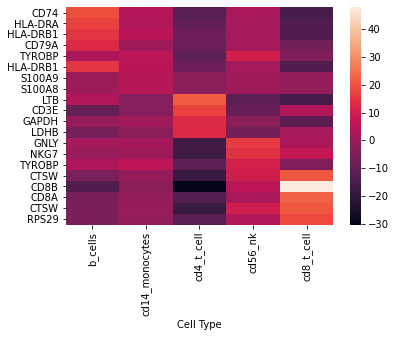

In [20]:
keep_genes = int_df.sort_values(0, ascending=False).head(4).index.tolist()
keep_genes += int_df.sort_values(1, ascending=False).head(4).index.tolist()
keep_genes += int_df.sort_values(2, ascending=False).head(4).index.tolist()
keep_genes += int_df.sort_values(3, ascending=False).head(4).index.tolist()
keep_genes += int_df.sort_values(4, ascending=False).head(4).index.tolist()
int_df.columns = cell_names
ax = sns.heatmap(int_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

In [29]:
int_df.loc[keep_genes,:]

,b_cells,cd14_monocytes,cd34,cd4_t_cell,cd56_nk,cd8_t_cell
CD74,23.028280,7.844861,7.117867,-23.998674,0.484068,-10.958111
HLA-DRA,20.550703,6.641532,7.058403,-20.337034,-0.839501,-11.454344
HLA-DRB1,18.000893,6.987773,3.675694,-15.676343,-0.664304,-11.306343
HLA-DPB1,16.351137,5.507708,4.831303,-16.857906,-0.593052,-7.320463
TYROBP,1.064735,8.092411,5.520627,-11.201632,12.154108,-5.426261
CD74,23.028280,7.844861,7.117867,-23.998674,0.484068,-10.958111
HLA-DRB1,18.000893,6.987773,3.675694,-15.676343,-0.664304,-11.306343
HLA-DRA,20.550703,6.641532,7.058403,-20.337034,-0.839501,-11.454344
GSTP1,1.188442,3.734811,7.499246,-9.217718,4.667435,-3.152863
AIF1,1.021200,3.756367,7.169282,-11.614655,1.482419,2.128209


In [34]:
int_df.loc["CD4",:]

b_cells          -0.781815
cd14_monocytes    0.133937
cd34             -0.302833
cd4_t_cell        3.132172
cd56_nk          -0.436225
cd8_t_cell       -3.261806
Name: CD4, dtype: float32

In [33]:
int_df.sort_values("cd4_t_cell", ascending=False).head(30)

,b_cells,cd14_monocytes,cd34,cd4_t_cell,cd56_nk,cd8_t_cell
CD3E,-12.002522,-7.415385,-8.726439,24.218397,-8.053568,1.421115
LTB,-0.346633,-7.033349,-10.417953,23.500202,-12.056223,-9.035088
LDHB,-10.126038,-6.519560,-1.473903,18.866829,-6.240820,-3.996928
IL32,-10.177980,-5.832559,-8.223896,18.531984,-5.320324,4.382749
S100A4,-9.275983,0.224410,0.278559,17.501913,0.626527,-15.109340
CD3D,-10.088745,-6.347070,-8.669763,15.166478,-7.019297,11.102195
VIM,-5.960861,-2.747719,-1.112851,14.779360,-4.462126,-8.283261
JUNB,-6.368446,-3.691166,-9.786414,14.404326,-5.959384,5.216513
TMEM66,-7.099599,-4.699313,-2.727879,13.068326,-3.916945,-0.450184
CD99,-5.870487,-2.188071,1.046048,12.940457,0.242535,-10.903715
